# Prediction of Health Measures Based on Location

**Data Scientist:** Elina Rankova

[IMAGE PLACEHOLDER]



## 1. Business Problem and Understanding

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
GradientBoostingRegressor, VotingRegressor, StackingRegressor

## 2. Data Understanding

In [2]:
# Load datasets

pl1 = pd.read_csv('Data/PLACES_2017-2018.csv')
pl2 = pd.read_csv('Data/PLACES_2018-2019.csv')
pl3 = pd.read_csv('Data/PLACES_2019-2020.csv')
pl4 = pd.read_csv('Data/PLACES_2020-2021.csv')
sdoh = pd.read_csv('Data/SDOH_2017-2021.csv')

We may want to check on the `StateAbbr` and `StateDesc` since it's showing the country in the preview. We also want to adjust the LocationName to either exclude 'county' or include 'county' to make sure both of the datasets are aligned in nomenclature.

Since the data we are working with is by county, we can eliminate the added specification with the `LocationName` in the SDOH dataset.

We will also have to deal with the differences in the `Year` column since it is an object in the SDOH data and an integer in the PLACES data.

In [3]:
# Concat all PLACES datasets
pl_all = pd.concat([pl1, pl2, pl3, pl4])
display(pl_all.tail())

sdoh.head()

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,High_Confidence_Limit,TotalPopulation,Latitude,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocatioin,LocationID,Geolocation
228765,2021,TX,Texas,Brown,BRFSS,Health Outcomes,High cholesterol among adults aged >=18 years ...,%,Crude prevalence,40.4,...,45.5,38192,NaN,HLTHOUT,HIGHCHOL,CrdPrv,High Cholesterol,NaN,48049.0,POINT (-98.998456 31.7641372)
228766,2021,TX,Texas,Grayson,BRFSS,Health Outcomes,Chronic kidney disease among adults aged >=18 ...,%,Age-adjusted prevalence,2.8,...,3.2,139336,NaN,HLTHOUT,KIDNEY,AgeAdjPrv,Chronic Kidney Disease,NaN,48181.0,POINT (-96.675693 33.624524)
228767,2021,SC,South Carolina,Richland,BRFSS,Health Risk Behaviors,No leisure-time physical activity among adults...,%,Crude prevalence,23.9,...,27.5,418307,NaN,RISKBEH,LPA,CrdPrv,Physical Inactivity,NaN,45079.0,POINT (-80.8980371 34.0290952)
228768,2021,WA,Washington,Franklin,BRFSS,Disability,Independent living disability among adults age...,%,Crude prevalence,8.4,...,9.8,98268,NaN,DISABLT,INDEPLIVE,CrdPrv,Independent Living Disability,NaN,53021.0,POINT (-118.9038912 46.5375019)
228769,2020,WI,Wisconsin,La Crosse,BRFSS,Health Outcomes,All teeth lost among adults aged >=65 years,%,Crude prevalence,8.1,...,11.8,120433,NaN,HLTHOUT,TEETHLOST,CrdPrv,All Teeth Lost,NaN,55063.0,POINT (-91.1117584 43.9082222)


,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,MOE,TotalPopulation,LocationID,CategoryID,MeasureID,DataValueTypeID,Short_Question_Text,Geolocation
0,2017-2021,AL,Alabama,Coosa County,5-year ACS,SDOH,Housing cost burden among households,%,Percentage,12.8,4.0,10442,1037,SDOH,HCOST,Percent,Housing cost burden,POINT (-86.2434818 32.9314453)
1,2017-2021,AL,Alabama,Lamar County,5-year ACS,SDOH,Persons living below 150% of the poverty level,%,Percentage,27.4,4.0,13929,1075,SDOH,POV150,Percent,Poverty,POINT (-88.0874309 33.7870852)
2,2017-2021,AK,Alaska,Aleutians East Borough,5-year ACS,SDOH,Crowding among housing units,%,Percentage,4.6,2.3,3409,2013,SDOH,CROWD,Percent,Crowding,POINT (-161.9974772 55.2450437)
3,2017-2021,AR,Arkansas,Dallas County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.3,2.2,6645,5039,SDOH,CROWD,Percent,Crowding,POINT (-92.6539989 33.9678233)
4,2017-2021,AR,Arkansas,Franklin County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.6,1.8,17159,5047,SDOH,CROWD,Percent,Crowding,POINT (-93.8876647 35.5085579)


In [4]:
# Lowercase all data to ensure consistancy
sdoh = sdoh.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
pl_all = pl_all.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Delete the 'county' specification
sdoh['LocationName'] = sdoh['LocationName'].str.replace('county',"")

In [5]:
print(sdoh.info())
print(pl_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28287 entries, 0 to 28286
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 28287 non-null  object 
 1   StateAbbr            28287 non-null  object 
 2   StateDesc            28287 non-null  object 
 3   LocationName         28278 non-null  object 
 4   DataSource           28287 non-null  object 
 5   Category             28287 non-null  object 
 6   Measure              28287 non-null  object 
 7   Data_Value_Unit      28287 non-null  object 
 8   Data_Value_Type      28287 non-null  object 
 9   Data_Value           28287 non-null  float64
 10  MOE                  28285 non-null  float64
 11  TotalPopulation      28287 non-null  int64  
 12  LocationID           28287 non-null  int64  
 13  CategoryID           28287 non-null  object 
 14  MeasureID            28287 non-null  object 
 15  DataValueTypeID      28287 non-null 

We will have to drop `Low_Confidence_Limit` and `High_Confidence_Limit` since the SDOH dataset does not have these columns.

In [6]:
print(sdoh.isna().sum()/sdoh.shape[0],'\n')
print(pl_all.isna().sum()/pl_all.shape[0])

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000318
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
MOE                    0.000071
TotalPopulation        0.000000
LocationID             0.000000
CategoryID             0.000000
MeasureID              0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
Geolocation            0.000318
dtype: float64 

Year                          0.000000
StateAbbr                     0.000000
StateDesc                     0.000000
LocationName                  0.000320
DataSource                    0.000000
Category                      0.000000
Measure                       0.000000
Data_Value_Unit               0.000000
Data_Value_Type               0.000000
Data_Value                    0.000000
Data_Value_Footno

In [7]:
# Merge all datasets together
df_all = pd.concat([pl_all, sdoh])

Right away we can tell that there are a few columns that are missing too many values and will need to be dropped.
- `Data_Value_Footnote_Symbol`
- `Data_Value_Footnote`
- `Latitude`
- `MOE`

`Geolocatioin` and `Geolocation` are the same feature when checking the source data websites only the 2020 release has a `Geolocatioin` column while the rest have `Geolocation`. `MeasureID` and `MeasureId` have the same issue it seems.

There are object type columns that will need to be transformed. Since state should be treated as a categorical variable we should adjust this in our dataset.

In addition, we would also want to make `LocationID` an object since this is not an actual continuous variable.

In [8]:
print(df_all.info(),'\n')

# Drop unneeded columns
df_all.drop(columns=['Data_Value_Footnote_Symbol','Data_Value_Footnote','Latitude',
                     'MOE','Low_Confidence_Limit','High_Confidence_Limit'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Year                        809177 non-null  object 
 1   StateAbbr                   809177 non-null  object 
 2   StateDesc                   809177 non-null  object 
 3   LocationName                808918 non-null  object 
 4   DataSource                  809177 non-null  object 
 5   Category                    809177 non-null  object 
 6   Measure                     809177 non-null  object 
 7   Data_Value_Unit             809177 non-null  object 
 8   Data_Value_Type             809177 non-null  object 
 9   Data_Value                  809177 non-null  float64
 10  Data_Value_Footnote_Symbol  0 non-null       float64
 11  Data_Value_Footnote         0 non-null       float64
 12  Low_Confidence_Limit        780890 non-null  float64
 13  High_Confidence_Limi

We can drop the misspelled `Geolocatioin` after filling in the nas in `Geolocation`. This concept applies to `MeasureID` and `MeasureId` as well.

In [9]:
# Fill NaNs in Geolocation and with Geolocatioin
df_all.loc[df_all['Geolocation'].isna(), 'Geolocation'] = df_all.loc[df_all['Geolocation'].isna(), 'Geolocatioin']

# Apply the same method to `MeasureID
df_all.loc[df_all['MeasureID'].isna(), 'MeasureID'] = df_all.loc[df_all['MeasureID'].isna(), 'MeasureId']

# Drop unneeded columns
df_all.drop(columns=['MeasureId','Geolocatioin'],axis=1,inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 809177 non-null  object 
 1   StateAbbr            809177 non-null  object 
 2   StateDesc            809177 non-null  object 
 3   LocationName         808918 non-null  object 
 4   DataSource           809177 non-null  object 
 5   Category             809177 non-null  object 
 6   Measure              809177 non-null  object 
 7   Data_Value_Unit      809177 non-null  object 
 8   Data_Value_Type      809177 non-null  object 
 9   Data_Value           809177 non-null  float64
 10  TotalPopulation      809177 non-null  int64  
 11  CategoryID           809177 non-null  object 
 12  DataValueTypeID      809177 non-null  object 
 13  Short_Question_Text  809177 non-null  object 
 14  LocationID           633169 non-null  float64
 15  Geolocation          80

We can drop nas in any columns we are not already dropping such as `LocationName` and the updated `Geolocation`. `LocationID` refers to the zipcode so we should first see if we can impute with the proper zipcode before droping nas.

In [10]:
print(df_all.isna().sum()/df_all.shape[0])

df_all.dropna(subset=['LocationName','Geolocation'],inplace=True)

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000320
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
TotalPopulation        0.000000
CategoryID             0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
LocationID             0.217515
Geolocation            0.000320
MeasureID              0.000000
dtype: float64


Looks like we were able to fill the nas using the associated `LocationID` with existing `Geolocation` as a unique identifier for the zipcode. 

In [11]:
# Filter rows with non-null LocationID
loc_df = df_all.loc[df_all['LocationID'].notna(), ['Geolocation', 'LocationID']]

# Create LocationName <> LocationID dictionary
loc_dict = dict(zip(loc_df['Geolocation'], loc_df['LocationID']))

# Fill missing LocationID values based on LocationName from the dictionary
df_all['LocationID'] = df_all['LocationID'].fillna(df_all['Geolocation'].map(loc_dict))

# Drop the rest of the nas in LocationID
df_all.dropna(inplace=True)

# Check the percentage of missing values in df_all after filling missing values
print(df_all.isna().sum() / df_all.shape[0])

Year                   0.0
StateAbbr              0.0
StateDesc              0.0
LocationName           0.0
DataSource             0.0
Category               0.0
Measure                0.0
Data_Value_Unit        0.0
Data_Value_Type        0.0
Data_Value             0.0
TotalPopulation        0.0
CategoryID             0.0
DataValueTypeID        0.0
Short_Question_Text    0.0
LocationID             0.0
Geolocation            0.0
MeasureID              0.0
dtype: float64


In [12]:
# Convert 'StateAbbr' and 'LocationID' columns to appropriate type
df_all['StateAbbr'] = df_all['StateAbbr'].astype('category')
df_all['LocationID'] = df_all['LocationID'].astype('object')

### Column Exploration

<ins>**Observations**</ins>

- We will likely drop `Year` as it can only provide relevant information for the data we retrieved from the PLACES datasets. Otherwise, we have the same date range as seen in the added SDOH data (2017-2021).
- Looks like we may want to drop the rows with US as the state as it is an error. We can also drop `StateDesc` since it's the same info as `StateAbbr`.
- `DataSource` can be dropped since all of the information is coming from the Behavioral Risk Factor Surveillance System or the 5-year American Community Survey which only contains SDOH data.
- `Data_Value_Unit` can be dropped since all of our data values are in percentages.
- `Data_Value_Type` will be helpful for interpretation of our predictions since it denotes what percentage the `Data_Value` represents. `DataValueTypeID` corresponds to this feature and can be dropped since `Data_Value_Type` is more informative.
- `CategoryID` corresponds to `Category` so we can drop it since `Category is easier to interpret.
- `MeasureId` corresponds the same way to `Measure`. However `Measure` values can be quite lengthy depending on the measure. We also have `Short_Question_Text' corresponding to these features and is more informative than `MeausureId` but shorter than `Measure` so we will keep `Short_Question_Text` and create a reference dictionary before dropping the other columns.

In [13]:
print(df_all['Year'].value_counts(),'\n')
print(df_all['StateAbbr'].value_counts(),'\n')
print(df_all['DataSource'].value_counts(),'\n')
print(df_all['Data_Value_Unit'].value_counts(),'\n')
print(df_all['Data_Value_Type'].value_counts(),'\n')
print(df_all['CategoryID'].value_counts(),'\n')
print(df_all['MeasureID'].value_counts(),'\n')
print(df_all['DataValueTypeID'].value_counts(),'\n')
print(df_all['Short_Question_Text'].value_counts(),'\n')

Year
2020         213724
2018         201040
2021         178408
2019         162284
2017-2021     28278
2017          25128
Name: count, dtype: int64 

StateAbbr
tx    65786
ga    41181
va    34391
ky    31080
mo    29785
ks    27195
il    26418
nc    25900
ia    25641
tn    24605
ne    24087
in    23828
oh    22792
mn    22533
mi    21497
ms    21238
ok    19943
ar    19425
wi    18648
al    17353
pa    17353
sd    17094
la    16576
co    16576
ny    16058
ca    15022
mt    14504
wv    14245
nd    13727
fl    13467
sc    11914
id    11396
wa    10101
or     9324
nm     8547
ak     7638
ut     7511
md     6216
wy     5957
nv     4403
nj     4347
me     4144
az     3885
ma     3626
vt     3626
nh     2590
ct     2072
ri     1295
hi     1286
de      777
dc      259
Name: count, dtype: int64 

DataSource
brfss         780584
5-year acs     28278
Name: count, dtype: int64 

Data_Value_Unit
%    808862
Name: count, dtype: int64 

Data_Value_Type
crude prevalence           390292
age-adjust

In [14]:
# Create reference dictionary for category and measure
measure_df = df_all[['Measure','Short_Question_Text','MeasureID']]
measure_dict = dict(zip(measure_df['MeasureID'], zip(measure_df['Short_Question_Text'], measure_df['Measure'])))
category_df = df_all[['Category','CategoryID']]
category_dict = dict(zip(category_df['Category'],category_df['CategoryID']))

In [15]:
# Drop rows with US as state
df_all = df_all.loc[df_all['StateAbbr'] != 'US']

# Drop other relevant columns
df_all.drop(columns=['DataSource','Data_Value_Unit','CategoryID','DataValueTypeID',
                     'StateDesc', 'MeasureID','Year','Measure'],inplace=True)
df_all.columns

Index(['StateAbbr', 'LocationName', 'Category', 'Data_Value_Type',
       'Data_Value', 'TotalPopulation', 'Short_Question_Text', 'LocationID',
       'Geolocation'],
      dtype='object')

Let's quickly check for duplicates since we had to download all of the PLACES datasets separately to accomodate the year range in the SDOH dataset.

In [16]:
dups = df_all.duplicated()
dups.value_counts()

False    808694
True        168
Name: count, dtype: int64

In [17]:
# Drop identified duplicates
df_all.drop_duplicates(ignore_index=True, inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808694 entries, 0 to 808693
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            808694 non-null  category
 1   LocationName         808694 non-null  object  
 2   Category             808694 non-null  object  
 3   Data_Value_Type      808694 non-null  object  
 4   Data_Value           808694 non-null  float64 
 5   TotalPopulation      808694 non-null  int64   
 6   Short_Question_Text  808694 non-null  object  
 7   LocationID           808694 non-null  object  
 8   Geolocation          808694 non-null  object  
dtypes: category(1), float64(1), int64(1), object(6)
memory usage: 50.1+ MB


In [18]:
# Save df_all as csv
df_all.to_csv('Data/df_all_clean.csv',index=False)

### Statistical Analysis

Before we move onto defining the target, we should look at the numerical distribution of the `Data_Value` and `TotalPopulation` columns. 

We can see there are some outliers in both columns we should consider visualizing and potentially dropping to get a more accurate representation of our distributions.

In [19]:
df_all[['Data_Value','TotalPopulation']].describe()

,Data_Value,TotalPopulation
count,808694.000000,8.086940e+05
mean,30.404016,1.033569e+05
std,24.766709,3.318928e+05
min,0.000000,5.700000e+01
25%,10.700000,1.080600e+04
50%,22.100000,2.562900e+04
75%,40.200000,6.749000e+04
max,99.400000,1.010552e+07


When visualizing these features, we can estimate that any `Data_Value` above ~85 is an outlier. It is harder to determine for `TotalPopulation`. We should look at the values of these more closely.

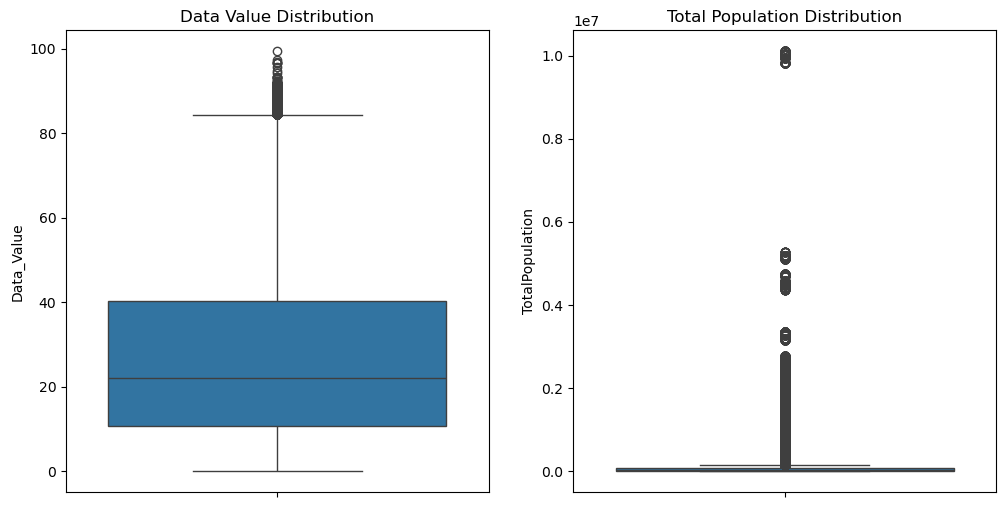

In [20]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
sns.boxplot(df_all['Data_Value'],ax=ax[0])
ax[0].set_title('Data Value Distribution')

sns.boxplot(df_all['TotalPopulation'],ax=ax[1])
ax[1].set_title('Total Population Distribution');

Looking at our z-score distribution there are around 10000 rows with a `TotalPopulation` greater than 3 standard deviations ouside the mean. All of the `Data_Value` is within 3 standard deviations within the mean so we won't drop those values quite yet. 

In [21]:
# Create subset df and get zscores
df_sub = df_all[['TotalPopulation','Data_Value']]
zscores = zscore(df_sub)

# Identify how many rows we would be dropping
print('Total Population > 3 std outside the mean:',zscores.loc[(zscores['TotalPopulation']<-3)|
      (zscores['TotalPopulation']>3)].shape[0])
print('Data Value > 3 std outside the mean:',zscores.loc[(zscores['Data_Value']<-3)|
      (zscores['Data_Value']>3)].shape[0])

Total Population > 3 std outside the mean: 10291
Data Value > 3 std outside the mean: 0


In [22]:
# Identify rows in df
outlier_rows = ((zscore(df_all['TotalPopulation'])>3)|(zscore(df_all['TotalPopulation'])<-3))

df_norm = df_all.loc[~outlier_rows]

print(df_all.shape)
print(df_norm.shape)

(808694, 9)
(798403, 9)


### Defining the Target

Now that our dataframe is aligned with our project goals, we can define our target variable `health_disparity_index`. 

To start, we will create a general index taking the average of all data values for each location and create a feature in the full dataset to represent this disparity index. For now, we will ignore Data_Value_Type, Measure, and Category.

In [23]:
# Isolate Geolocation & Data_Value without specifying or paying attention to Data_Value_type 
avg_idx = df_all[['Geolocation','Data_Value']]

# Aggregate average Data_Value per Geolocation
avg_idx = avg_idx.groupby(by=['Geolocation']).mean().reset_index()
avg_idx_dict = dict(zip(avg_idx['Geolocation'], avg_idx['Data_Value']))

# Copy dataframe
df_avg_idx = df_all.copy()

# Create Avg_Idx column
df_avg_idx['Avg_Idx'] = df_avg_idx['Geolocation'].map(avg_idx_dict)

Comparing random samples of `Avg_Idx` vs `Data_Value` shows us that there is a lot more variablity in the `Data_Value` before aggregation of all of the data value types. 

There is slighly less variabily in `Avg_Idx` when we plot by `Geolocation` but we should still test different approaches when defining our disparity index to see if we can get an even better representation.

This may mean that a direct mean of all the data value types is not a good reprentation of the disparity index.

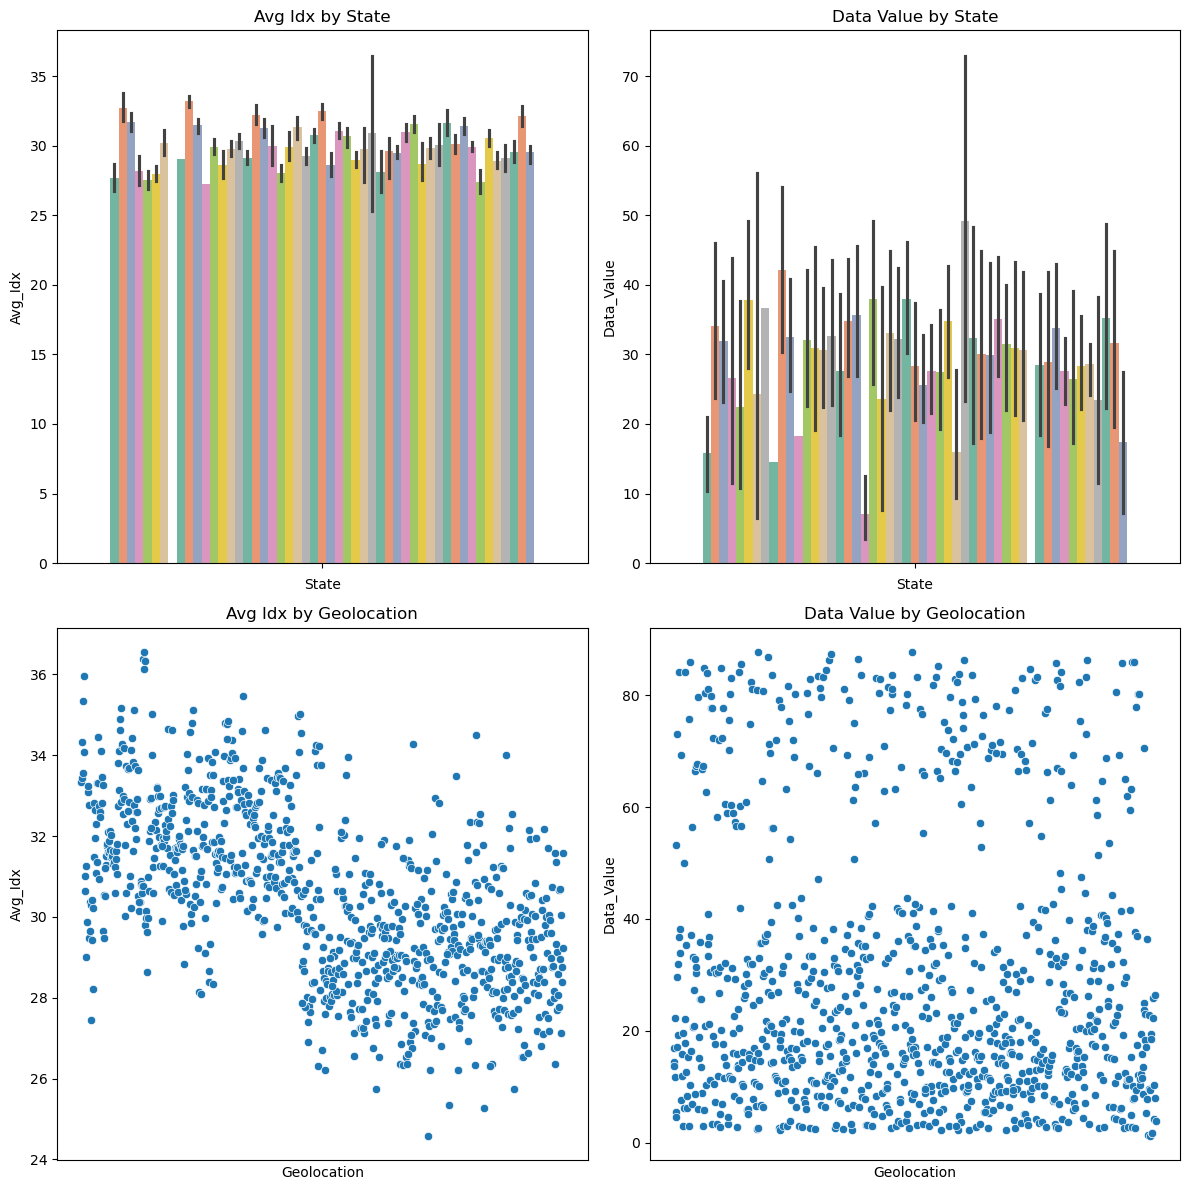

In [24]:
# Helper plotting function

def idx_plot(data,y1,y2,y1_name,y2_name):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

    # Visualize by State
    # Plot by y2
    sns.barplot(data=data, hue='StateAbbr', y=y1.sample(n=1000), 
                palette='Set2', ax=ax[0,0],legend=False)
    ax[0,0].set_title(f'{y1_name} by State')
    ax[0,0].set_xlabel('State')
    
    # Plot by y1
    sns.barplot(data=data, hue='StateAbbr', y=y2.sample(n=1000), 
                palette='Set2', ax=ax[0,1],legend=False)
    ax[0,1].set_title(f'{y2_name} by State')
    ax[0,1].set_xlabel('State') 
    
    # Visualize by Geolocation
    # Plot by y1
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y1, ax=ax[1, 0])
    ax[1, 0].set_title(f'{y1_name} by Geolocation')
    ax[1, 0].set_xlabel('Geolocation')

    ax[1,0].set_xticks([])
    
    # Plot by y2
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y2, ax=ax[1, 1])
    ax[1, 1].set_title(f'{y2_name} by Geolocation')
    ax[1, 1].set_xlabel('Geolocation')

    ax[1,1].set_xticks([])

    plt.tight_layout() 
    plt.show();

idx_plot(df_avg_idx,df_avg_idx['Avg_Idx'],df_avg_idx['Data_Value'],'Avg Idx','Data Value')

Let's try to add a population weight to our `Avg_Idx` based on the total impacted population for each geolocation.

In [25]:
# Isolate Geolocation & TotalPopulation
tot_pop = df_all[['Geolocation','TotalPopulation']]

# Aggregate TotalPopulation per Geolocation
tot_pop = tot_pop.groupby(by=['Geolocation']).sum().reset_index()
tot_pop_dict = dict(zip(tot_pop['Geolocation'], tot_pop['TotalPopulation']))

# Copy dataframe
df_pw_idx = df_avg_idx.copy()

# Create Tot_Pop column
df_pw_idx['Tot_Pop'] = df_pw_idx['Geolocation'].map(tot_pop_dict)

df_pw_idx['Weighed_Idx'] = df_pw_idx['Avg_Idx']*(df_pw_idx['TotalPopulation']/df_pw_idx['Tot_Pop'])

This gives us slightly more variation among the state aggregation but does the opposite for geolocation and since we are primarily focusing on geolocation as our unique location identifier, this approach takes us away from our goal.

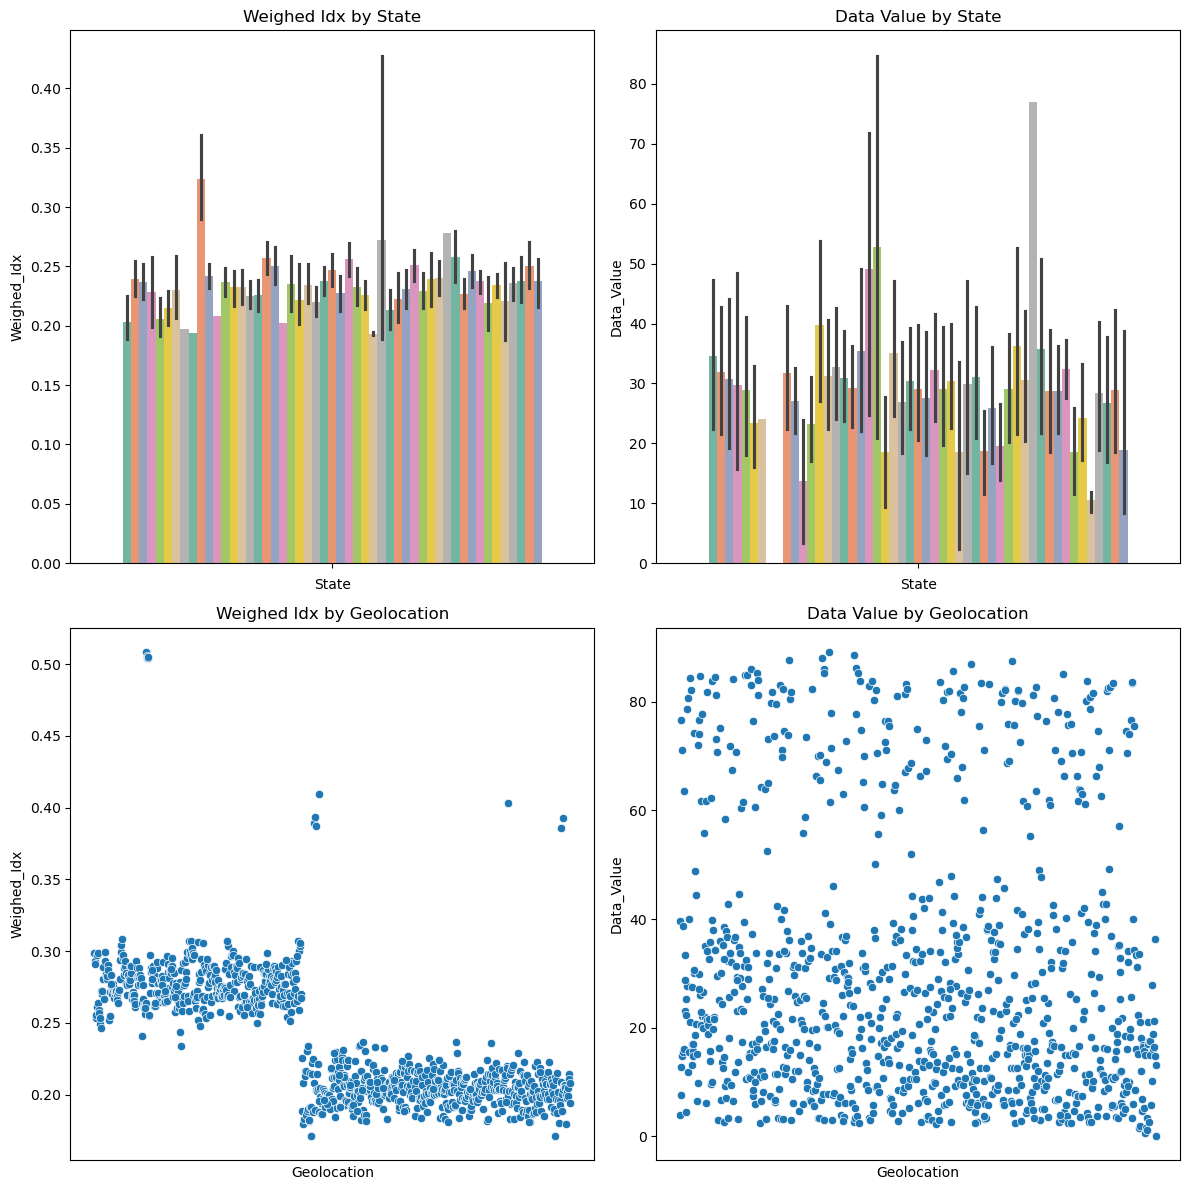

In [26]:
idx_plot(df_pw_idx,df_pw_idx['Weighed_Idx'],df_pw_idx['Data_Value'],'Weighed Idx','Data Value')

In [51]:
# Isolate Geolocation & Short Question Text
df_cat = df_all[['Geolocation','Short_Question_Text']]

# Aggregate Short Question Text per Geolocation
df_cat = df_cat.groupby('Geolocation')['Short_Question_Text'].value_counts().reset_index(name='Short_Question_Count')
df_cat = cat_counts.groupby('Geolocation').sum().reset_index()
tot_pop_dict = dict(zip(tot_pop['Geolocation'], tot_pop['TotalPopulation']))

# Copy dataframe
df_cw_idx = df_avg_idx.copy()

# Create Short_Question_Count column
df_cw_idx['Short_Question_Count'] = df_cw_idx['Geolocation'].map(tot_pop_dict)

# Create weighed index column
df_cw_idx['Weighed_Cat_Idx'] = df_cw_idx['Avg_Idx']*(df_cw_idx['Short_Question_Count']/
                                                     df_cw_idx['Short_Question_Text'].nunique())

df_cw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808694 entries, 0 to 808693
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   StateAbbr             808694 non-null  category
 1   LocationName          808694 non-null  object  
 2   Category              808694 non-null  object  
 3   Data_Value_Type       808694 non-null  object  
 4   Data_Value            808694 non-null  float64 
 5   TotalPopulation       808694 non-null  int64   
 6   Short_Question_Text   808694 non-null  object  
 7   LocationID            808694 non-null  object  
 8   Geolocation           808694 non-null  object  
 9   Avg_Idx               808694 non-null  float64 
 10  Short_Question_Count  808694 non-null  int64   
 11  Weighed_Cat_Idx       808694 non-null  float64 
dtypes: category(1), float64(3), int64(2), object(6)
memory usage: 68.6+ MB


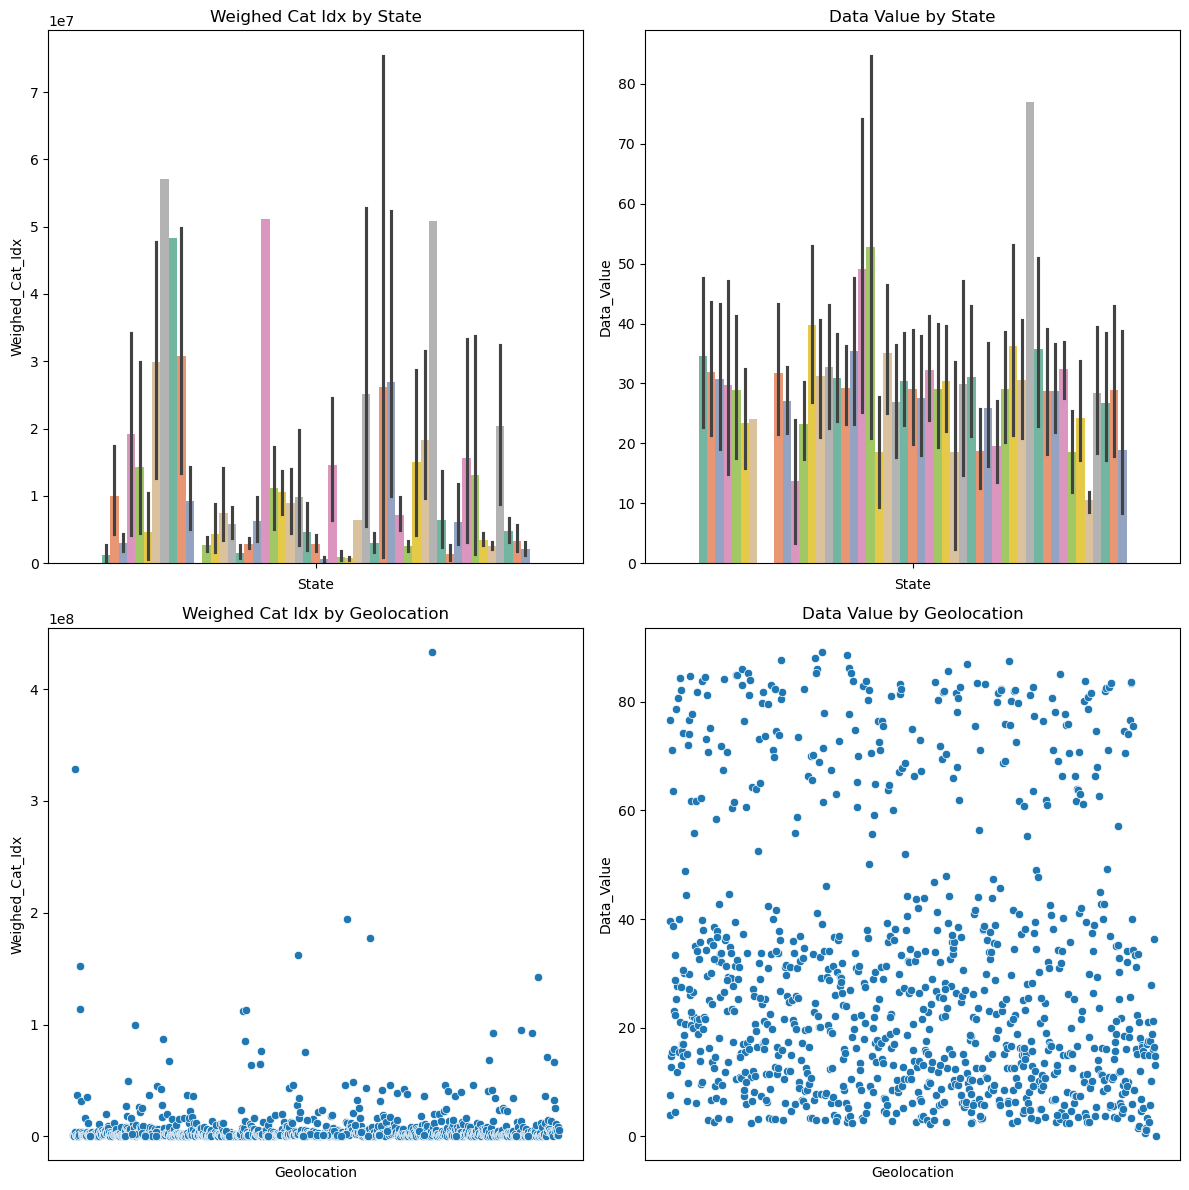

In [49]:
idx_plot(df_cw_idx,df_cw_idx['Weighed_Cat_Idx'],df_cw_idx['Data_Value'],'Weighed Cat Idx','Data Value')

## 3. Data Preparation

Since our dataset is so large we will train our model on a smaller training set to save computational power and time.

In [52]:
# Define X, y, and split data

X = df_cw_idx.drop(columns=['Weighed_Cat_Idx'])
y = df_cw_idx['Weighed_Cat_Idx']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

# Split data into mini-batches
X_batch = np.array_split(X_train.values,20)
y_batch = np.array_split(y_train.values,20)

# Initialize StratifiedShuffleSplit
strat_splitter = StratifiedShuffleSplit(n_splits=1,train_size=.1)

# Generate indices for the stratified sample
for train_index, _ in strat_splitter.split(X_train, y_train):
    X_sampled = X.iloc[train_index]
    y_sampled = y.iloc[train_index]

X_samp_train, X_samp_test, y_samp_train, y_samp_test = train_test_split(X_sampled,y_sampled)

In [53]:
# Define num and cat subpipes
subpipe_num = Pipeline(steps=[('ss',StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# Initiate ColumnTranformer
CT = ColumnTransformer(transformers=[('subpipe_num',subpipe_num,[4,5,10]),
                                    ('subpipe_cat',subpipe_cat,[0,1,2,3,6,7,8])],
                      remainder='passthrough')

# Initial Pipeline
init_pipe = Pipeline(steps=[('ct',CT),
                           ('model',LinearRegression())])

In [54]:
init_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5, 10]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7, 8])])),
                ('model', LinearRegression())])

In [55]:
# Baseline Metrics
print('Train RSME:', root_mean_squared_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test RSME:', root_mean_squared_error(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train R-Squared:', r2_score(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test R-Squared:', r2_score(y_samp_test,init_pipe.predict(X_samp_test)))
print('Train MAE:', mean_absolute_error(y_samp_train,init_pipe.predict(X_samp_train)))
print('Test MAE:', mean_absolute_error(y_samp_test,init_pipe.predict(X_samp_test)))

Train RSME: 3.573117686875804e-07
Test RSME: 8605.074618122353
Train R-Squared: 1.0
Test R-Squared: 0.9999998735770413
Train MAE: 2.0281349699412483e-07
Test MAE: 294.91783881668266


## Linear Regression Model

Let's see if we can address the overfitting we are seeing in our baseline metrics.

### Lasso

In [43]:
# Replace in pipeline

lasso_pipe = init_pipe.set_params(model=Lasso())
lasso_pipe.fit(X_samp_train,y_samp_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [4, 5]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [0, 1, 2, 3, 6, 7, 8])])),
                ('model', Lasso())])

In [ ]:
# Define your parameter grid
params_lasso = {
    'model__alpha':[.0001,.001,.01,1,10,100,1000],
    'model__selection': ['cyclic','random']
    
}

rcv_lasso=RandomizedSearchCV(lasso_pipe,param_distributions=params_lasso,scoring='neg_root_mean_squared_error',
                 return_train_score=True,cv=5,n_iter=10,verbose=3)

rcv_lasso.fit(X_samp_train,y_samp_train)
rcv_lasso.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__alpha=100, model__selection=cyclic;, score=(train=-2.074, test=-2.079) total time=   3.8s
[CV 2/5] END model__alpha=100, model__selection=cyclic;, score=(train=-2.073, test=-2.084) total time=   3.9s
[CV 3/5] END model__alpha=100, model__selection=cyclic;, score=(train=-2.068, test=-2.104) total time=   3.6s
[CV 4/5] END model__alpha=100, model__selection=cyclic;, score=(train=-2.083, test=-2.045) total time=   3.6s
[CV 5/5] END model__alpha=100, model__selection=cyclic;, score=(train=-2.078, test=-2.065) total time=   3.8s


In [ ]:
# Create quick function to see the scores easier for future models
def rcv_metrics(rcv,model_name,X,y,train_df=None):
    best_estimator = rcv.best_estimator_
    score_dict = {'Val Train Score': -np.mean(rcv.cv_results_['mean_train_score']),
                 'Val Test Score':-np.mean(rcv.cv_results_['mean_test_score']),
                 'Model Name': model_name}
    score_df = pd.DataFrame(score_dict,columns=['Model Name','Val Train Score',
                                                'Val Test Score'], index=range(1))
    if train_df is None:
        pass
    else:
       score_df = pd.concat([train_df,score_df])
       score_df.index = range(len(score_df))
    return score_df, best_estimator
    
train_scores, lasso_best = rcv_metrics(rcv_lasso,'Lasso',X_samp_train,y_samp_train)
train_scores